### **Survey Responses Logistic Regression Model**

###### The objective of this logistic regression model is to identify factors associated with participants' likelihood of responding to our monthly pulse survey. The dataset includes 3,282 observations, with approximately 10% of participants having responded. Key predictors examined in the model include race, primary language, gender, the name of the program in which the participant is enrolled and whether the participant responded to our annual survey.

###### **Author:** Gretter Cabrera
###### **Collaborator:** Shaheen Eshghipour
###### **Creation Date:** 06/25/2025


#### **Import Libraries**

In [2]:
library(tidyverse)  

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 3, Finished, Available, Finished)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ ggplot2   3.5.1     ✔ tidyr     1.3.1
✔ lubridate 1.9.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()       masks SparkR::arrange()
✖ dplyr::between()       masks SparkR::between()
✖ dplyr::coalesce()      masks SparkR::coalesce()
✖ dplyr::collect()       masks SparkR::collect(), sparklyr::collect()
✖ dplyr::contains()      masks tidyr::contains(), SparkR::contains()
✖ dplyr::count()         masks SparkR::count()
✖ dplyr::cume_dist()     masks SparkR::cume_dist()
✖ dplyr::dense_rank()    masks SparkR::dense_rank()
✖ dplyr::desc()          masks SparkR::desc()
✖ dplyr::distinct()      masks SparkR::distinct(), sparklyr::distinct()
✖ dplyr::explain()       masks SparkR::explain()
✖ dplyr::expr()          masks ggplot2::expr(), SparkR::expr()
✖ tidyr::extract()       mas

#### **Load data and select variables**
The data consist of pulse survey respondents for 4/25. Demographics data and binary responded Y/N to the annual survey are also included.

In [3]:
responses_df    = read.csv("/lakehouse/default/Files/Survey Sparrow/april_response_dataset.csv")
demographics_df = read.csv("/lakehouse/default/Files/Survey Sparrow/participant_data.csv")
annual_survey_df = read.csv("/lakehouse/default/Files/Survey Sparrow/annual_survey.csv")

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 4, Finished, Available, Finished)

In [4]:
# reduce demographics df
dem_vars        = c('PII.Participant_ID', 'Demographics.Age', 'Demographics.Gender')
demographics_df = demographics_df[,dem_vars]

# reduce survey df
survey_vars  = c('panda_id', 'programname', 'sfmfb_language', 'race', 'preferred_contact_method', 'Responded')
responses_df = responses_df[,survey_vars]

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 5, Finished, Available, Finished)

#### **Data cleaning** 
Removed duplicates and combined low proportion categories (under 4 and 5% of total count) for gender, race and language into "Other" category 

In [5]:
# remove duplicates and unknowns
demographics_df = demographics_df[!duplicated(demographics_df[,'PII.Participant_ID']) & demographics_df[,"PII.Participant_ID"] != "Unknown",]

# merge low n gender categories to 'other'
high.prop.genders = names(which(prop.table(table(demographics_df$Demographics.Gender)) > 0.05))
demographics_df$Demographics.Gender = ifelse(
  demographics_df$Demographics.Gender %in% high.prop.genders,
  demographics_df$Demographics.Gender,
  "Other"
)

# merge low n race categories to 'other'
high.prop.races = names(which(prop.table(table(responses_df$race)) > 0.04))
responses_df$race = ifelse(
 responses_df$race %in% high.prop.races & responses_df$race != "",
 responses_df$race,
 "Other"
)

# merge low n language categories to 'other'
high.prop.lang = names(which(prop.table(table(responses_df$sfmfb_language)) > 0.04))
responses_df$sfmfb_language = ifelse(
 responses_df$sfmfb_language %in% high.prop.lang & responses_df$sfmfb_language != "",
 responses_df$sfmfb_language,
 "Other"
)

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 6, Finished, Available, Finished)

#### **Merge data and change data types**

In [6]:
# first merge and remove redundant column
merged_df = merge(demographics_df, responses_df, by.x = 'PII.Participant_ID', by.y = 'panda_id')

# second merge to annual survey
merged_df = merge(merged_df, annual_survey_df, by.x = 'PII.Participant_ID' , by.y = 'PanDa.ID', all.x=TRUE)

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 7, Finished, Available, Finished)

In [7]:
# add var for responded to annual survey y/n
merged_df$annual_survey_response = ifelse(!is.na(merged_df$Submitted.On), 1, 0)

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 8, Finished, Available, Finished)

In [8]:
# change select vars to factor
factor_vars            = c('Demographics.Gender','race', 'sfmfb_language','programname','preferred_contact_method', 'annual_survey_response')
merged_df[factor_vars] = lapply(merged_df[factor_vars] , factor)

# change select vars to numeric
num_vars            = c('Responded','Demographics.Age')
merged_df[num_vars] = lapply(merged_df[num_vars] , as.numeric)

# add normalized version of age var
merged_df$Demographics.Age_scaled = scale(merged_df$Demographics.Age)

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 9, Finished, Available, Finished)

In [9]:
# re-order program var
merged_df$programname <- factor(merged_df$programname, levels = c("Neighborhood Pantry", "Brown Bag Pantry", "Healthy Children Pantry", "Home Delivered Grocery", "Pop-Up Pantry"))

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 10, Finished, Available, Finished)

#### **Bootstrap**
A small and unbalanced (90/10 split) dataset is used for the analysis. Therefore bootstrapping is applied for a more robust analysis.

Bootstrapping randomly samples a dataset with replacement and a logistic regression is subsequently run on each resampled dataset. This process is repeated B=1000 and model coefficients for each run are stored in a matrix.

In [10]:
# --  initialize model

model = glm(Responded ~ Demographics.Age + Demographics.Gender + race + sfmfb_language + programname + preferred_contact_method + annual_survey_response, family = 'binomial', data = merged_df)
names = names(model$coefficients)
nvars = length(names)

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 11, Finished, Available, Finished)

In [11]:
# -- run bootstrap

set.seed(0825)

# - variables
B  = 1000
mat = matrix(nrow = B, ncol=nvars)
colnames(mat) = names
R.squared_vec = rep(NA,nrow(mat))


for(b in 1:B){

    # sample dataframe with replacement
    sample_df = merged_df[base::sample(1:nrow(merged_df), replace = TRUE), ]

    # run logistic regression
    model = glm(Responded ~ Demographics.Age + Demographics.Gender + race + sfmfb_language + programname + preferred_contact_method + annual_survey_response, family = 'binomial', data = sample_df)

    # extract coefficients
    coeff = model$coefficients

    # append to matrix
    mat[b,] = coeff

    # get psuedo R squared
    R.squared_vec[b] = with(summary(model), 1 - deviance/null.deviance)

}

# exponentiate the coefficients
mat = exp(mat)


StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 12, Finished, Available, Finished)

#### **Summary Table**
A summary table is created to display mean odds ratio for all coefficients along with confidence intervals and p values. A confidence level of 90% is used, assuming a 10% chance of error. 90% confidence intervals are more common in social science where researchers are interested in detecting less precise effects.

In [12]:
# -- rename columns

colnames(mat) = gsub("Demographics\\.", "", colnames(mat))
colnames(mat) = gsub("Gender", "Gender = ", colnames(mat))
colnames(mat) = gsub("annual_survey_response1", "Responded to Annual Survey", colnames(mat))
colnames(mat) = gsub("preferred_contact_method", "Preferred Contact Method = ", colnames(mat))
colnames(mat) = gsub("programname", "Program Name = ", colnames(mat))
colnames(mat) = gsub("race", "Race = ", colnames(mat))
colnames(mat) = gsub("sfmfb_language", "Language = ", colnames(mat))

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 13, Finished, Available, Finished)

In [13]:
# -- create table

summary_table = as.data.frame(mat) %>%
  pivot_longer(cols = everything(), names_to = "Predictor", values_to = "OddsRatio") %>%
  dplyr::group_by(Predictor) %>%
  dplyr::summarize(
    `Odds Ratio` = mean(OddsRatio),
    CI_lower = quantile(OddsRatio, 0.05),   # 90% CI
    CI_upper = quantile(OddsRatio, 0.95),
    p_value = 2 * pmin(
      mean(OddsRatio < 1),
      mean(OddsRatio > 1)
    ),
    .groups = "drop"
  ) %>%
  mutate(
    `Odds Ratio` = round(`Odds Ratio`, 2),
    CI = paste0("[", round(CI_lower, 2), ", ", round(CI_upper, 2), "]"),
    p = ifelse(p_value < 0.001, "<0.001", round(p_value, 2)),
    Significant = ifelse(CI_lower > 1 | CI_upper < 1, "Yes", "No")
  ) %>%
  select(Predictor, `Odds Ratio`, CI, p, Significant)


StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 14, Finished, Available, Finished)

In [14]:
# -- print results

options(scipen = 999) # disable scientific notation

# print
n_obs = nobs(model)
options(width = 200)
R.squared.mean = mean(R.squared_vec)
cat("Outcome: Responded\n\n")
print(as.data.frame(summary_table), row.names = FALSE)
cat("\nObservations:", n_obs)
cat("\nPseudo R²:",round(R.squared.mean, 3) , "\n")

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 15, Finished, Available, Finished)

Outcome: Responded

                                    Predictor Odds Ratio           CI      p Significant
                                  (Intercept)       0.19  [0.11, 0.3] <0.001         Yes
                                          Age       1.00    [0.99, 1]    0.3          No
                                Gender = MALE       0.96 [0.77, 1.17]   0.72          No
                               Gender = Other       1.39 [0.52, 2.64]    0.6          No
                           Language = English       1.11 [0.83, 1.45]   0.56          No
                             Language = Other       0.99  [0.65, 1.4]   0.85          No
                           Language = Spanish       1.08 [0.57, 1.83]   0.96          No
             Preferred Contact Method = Phone       0.54 [0.43, 0.66] <0.001         Yes
              Program Name = Brown Bag Pantry       0.45  [0.2, 0.74]   0.01         Yes
       Program Name = Healthy Children Pantry       0.15    [0, 0.36] <0.001         Yes
 

#### **Boxplot Visualtization of Model Coefficients**
The further away the distributions are from 1 the more significant the variable is in predicting the outcome. In this case predicting survey responses. 

In [21]:
# -- dataset for visualization

boot_long = pivot_longer(as.data.frame(mat), 
                          cols = everything(), 
                          names_to ="Variables",
                          values_to = "OddsRatio")

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 22, Finished, Available, Finished)

In [22]:
# -- change names in summary table
names(summary_table)[1] = "Variables"

#-- trim variable names and convert to lower case
boot_long$Variables = trimws(tolower(boot_long$Variables))
summary_table$Variables = trimws(tolower(summary_table$Variables))

#-- merge summary table and bootlong pivot
boot_long = merge(
  boot_long,
  summary_table[, c("Variables", "Significant")],
  by = "Variables",
  all.x = TRUE
)

#-- add * if variable is significant
boot_long$VariableLabel = ifelse(boot_long$Significant == "Yes",paste0(boot_long$Variables, " *"),boot_long$Variables)


StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 23, Finished, Available, Finished)

StatementMeta(, edb513b2-11ae-4059-8732-d251f3a67781, 24, Finished, Available, Finished)

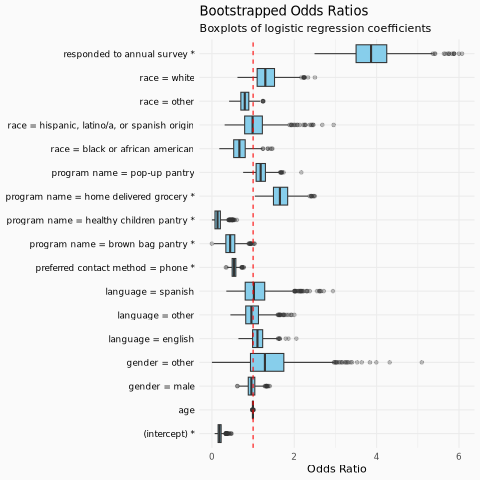

In [23]:
# plot
plot = ggplot(boot_long, aes(y = VariableLabel, x = OddsRatio)) +
  geom_boxplot(fill = "skyblue", outlier.alpha = 0.3) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(color = "black"),
    plot.background = element_rect(fill = "grey98", color = NA),
    panel.background = element_rect(fill = "grey98", color = NA)
  ) +
  labs(
    title = "Bootstrapped Odds Ratios",
    subtitle = "Boxplots of logistic regression coefficients",
    x = "Odds Ratio",
    y = NULL
  )

plot